In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import os
import keras
import sklearn

#1- Normalisation des images

In [2]:
#!pip uninstall dlib
#!pip install dlib

In [3]:
hog_detector = dlib.get_frontal_face_detector()
#cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')

def face_locations(image, model="hog"):


    detector = hog_detector
    cst = 0
    #elif model == "cnn":
    #    detector = cnn_detector
    #    cst = 10

    matches = detector(image,1)
    rects   = []

    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))

    return rects

In [4]:
def extract_faces(image, model="hog"):

    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = face_locations(gray, model)
    faces = []

    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)

    return faces

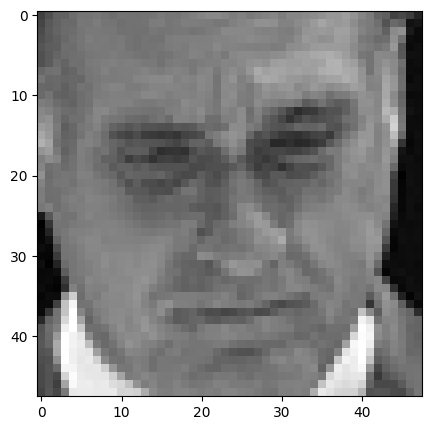

In [5]:
image = cv2.imread("/content/drive/MyDrive/Projet Vision Numérique/archive.zip (Unzipped Files)/Train provisoire/Training_99746769.jpg")
image1 = cv2.imread("/content/drive/MyDrive/Projet Vision Numérique/archive.zip (Unzipped Files)/Train provisoire/Training_99746769.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,5))
plt.imshow(image)

In [6]:
location = face_locations(image)
print(location)


[(2, 7, 43, 41)]


In [7]:
faces = extract_faces(image)
print(len(faces))

1


In [8]:
def show_grid(faces, figsize=(8,8)):
    face = faces[0]
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(face)
    ax.axis('off')

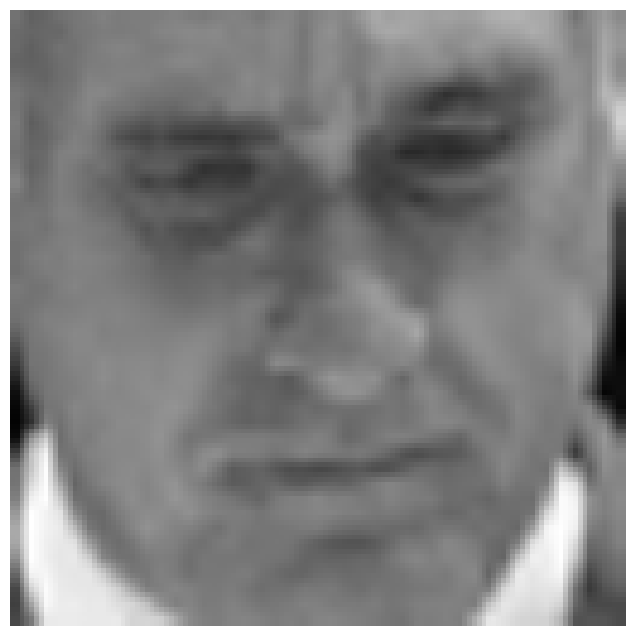

In [9]:
show_grid(faces)

In [10]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):

    imagePaths = []

    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)

    return imagePaths

#2- Estimation du visage

In [12]:
pose68 = dlib.shape_predictor('/content/drive/MyDrive/Projet Vision Numérique/archive.zip (Unzipped Files)/models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('/content/drive/MyDrive/Projet Vision Numérique/archive.zip (Unzipped Files)/models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):

    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05

    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [13]:
marks = face_landmarks(faces)

In [14]:
def shape_to_coords(shape):
    return np.float32([[p.x, p.y] for p in shape.parts()])

In [15]:
TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

INNER_EYES_AND_BOTTOM_LIP = np.array([39, 42, 57])
OUTER_EYES_AND_NOSE = np.array([36, 45, 33])

In [16]:
def align_faces(images, landmarks, idx=INNER_EYES_AND_BOTTOM_LIP):
    faces = []
    for (img, marks) in zip(images, landmarks):
        imgDim = img.shape[0]
        coords = shape_to_coords(marks)
        H = cv2.getAffineTransform(coords[idx], imgDim * MINMAX_TEMPLATE[idx])
        warped = cv2.warpAffine(img, H, (imgDim, imgDim))
        faces.append(warped)
    return faces

In [18]:
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [19]:
landmarks = face_landmarks(faces)

In [20]:
new_faces = []
for (face,shape) in zip(faces, landmarks):
    canvas = face.copy()
    coords = shape_to_coords(shape)
    for p in coords:
        cv2.circle(canvas, (int(p[0]),int(p[1])), 1, (0, 0, 255), -1)
    new_faces.append(canvas)

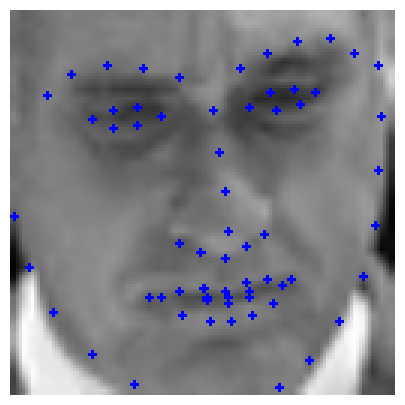

In [21]:
show_grid(new_faces, figsize=(15,5))

In [22]:
aligned = align_faces(faces, landmarks)

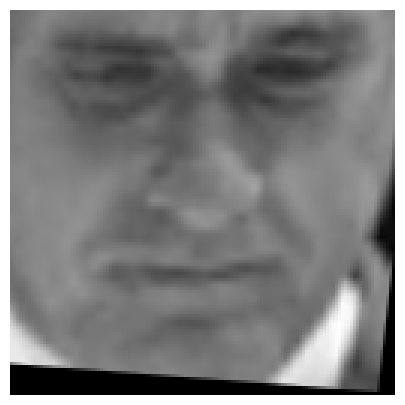

In [23]:
show_grid(aligned, figsize=(15,5))

In [24]:
landmarks = face_landmarks(aligned)

In [25]:
new_faces = []
for (face,shape) in zip(aligned, landmarks):
    canvas = face.copy()
    coords = shape_to_coords(shape)
    for p in coords:
        cv2.circle(canvas, (int(p[0]),int(p[1])), 1, (0, 0, 255), -1)
    new_faces.append(canvas)

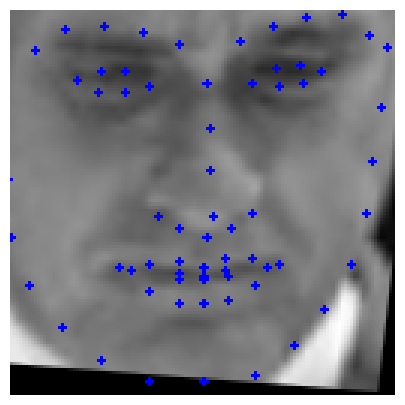

In [26]:
show_grid(new_faces, figsize=(15,5))